# Introduction

The following uses KNearestNeighbor to fit a classifier that distinguishes between a pair of sketch categories from the Quick, Draw! dataset from Google:

https://console.cloud.google.com/storage/browser/quickdraw_dataset/full/numpy_bitmap/?pli=1

Categories were chosen below to make a somewhat difficult comparison (two objects that typically look alike)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import copy
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold, cross_validate
from sklearn.neighbors import KNeighborsClassifier

from utilities import computeLearningCurve, plotScoreCurve, plotTimeCurve, plotIterationCurve, plotConfusionMatrix, getDrawData, drawIncorrectSketches

# Settings

In [3]:
# Random seed used for all "random" generators
randomSeed = 1

# Number of parallel jobs used for some sklearn routines (-1 means use all cpus)
njobs = -1

# Fractional size of test dataset
testSize = 1/5.

# Number of folds for GridSearchCV
nfolds = 5

# Settings to control which features are used
pRows = 28
pCols = 28
pColNames = list(range(pRows * pCols))
pScale = 255.0 # Scale factor for pixels.  Pixel raw data is 0 to 255.  Set to 1 to avoid scaling

# Number of samples PER CATEGORY (defined below)
nSamples = 7500

# Names of all models to include
# names = ['baseball', 'basketball', 'camel', 'cow', 'clock', 'wristwatch']
names = ['baseball', 'basketball']

# Plot min/max extents for all accuracy plots
accuracyMin = 0.6
accuracyMax = 1.0

# Folds (denoted by number of data points used) for learning curve
learningCurveFolds = np.concatenate([np.geomspace(10, 1000, 5).round(), np.array([2000, 4000, 6000, 9000])]).astype('int')

In [4]:
# Used for plot names
est = "quickdraw_knn"
scoreText = "Score (Classification Accuracy)"

# Load Data

In [5]:
dataDict = getDrawData(names, nSamples=nSamples)
data = dataDict['df']
nameDict = dataDict['nameDict']

print("")
print("Loaded the following named categories, with classNumbers shown")
print(nameDict)

# Scale pixel data
for col in pColNames:
    data[col] = data[col] / pScale

Loading 7500 samples for baseball from ./data/full_numpy_bitmap_baseball.npy
Loading 7500 samples for basketball from ./data/full_numpy_bitmap_basketball.npy

Loaded the following named categories, with classNumbers shown
{'baseball': 0, 'basketball': 1}


In [6]:
# Create X, y, XTest, yTest using just the features we care about...

XFull = data.loc[:, pColNames].values
print(f'XFull.shape = {XFull.shape}')
yFull = data.loc[:, 'classNumber'].values
print(f'yFull.shape = {yFull.shape}')

X, XTest, y, yTest = train_test_split(XFull, yFull, test_size=testSize, 
                                      random_state=randomSeed, stratify=yFull)

print('')
print(f'X.shape = {X.shape}')
print(f'y.shape = {y.shape}')
print(f'Ratio of y=1 to y=0 for Training data: {(y == 1).sum() / float(len(y))} (should be 0.5)')

print('')
print(f'XTest.shape = {XTest.shape}')
print(f'yTest.shape = {yTest.shape}')
print(f'Ratio of yTest=1 to yTest=0 for Test data: {(yTest == 1).sum() / float(len(yTest))} (should be 0.5)')

XFull.shape = (15000, 784)
yFull.shape = (15000,)

X.shape = (12000, 784)
y.shape = (12000,)
Ratio of y=1 to y=0 for Training data: 0.5 (should be 0.5)

XTest.shape = (3000, 784)
yTest.shape = (3000,)
Ratio of yTest=1 to yTest=0 for Test data: 0.5 (should be 0.5)


# Initial Parameter Setting using GridSearchCV with Nominal Data Set

Examine the hyperparameter space using GridSearchCV.

In [7]:
paramGrid = {
    'n_neighbors': [1, 2, 3, 5, 7, 10, 20],
    'weights': ['distance', 'uniform'],
}

nData = 2000
XSubset = X[:nData]
ySubset = y[:nData]

gs = GridSearchCV(KNeighborsClassifier(), param_grid=paramGrid, cv=nfolds, n_jobs=njobs, 
                      verbose=10, return_train_score=True)

In [8]:
# fit!
print(f"Fitting model using {XSubset.shape[0]} data samples")
gs.fit(XSubset, ySubset)

pltNameSuffix = '_initial'
with open(est + pltNameSuffix + "_gs.pkl", 'wb') as fout:
    pickle.dump(gs, file=fout)

Fitting model using 2000 data samples
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   48.0s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   59.0s
[Parallel(n_jobs=-1)]: Done  63 out of  70 | elapsed:  1.3min remaining:    8.7s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  1.4min finished


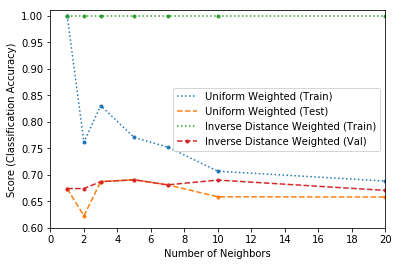

In [9]:
gs_results_df = pd.DataFrame(gs.cv_results_)

fig, ax = plt.subplots()

gs_results_df.loc[gs_results_df.param_weights == 'uniform'].plot(x='param_n_neighbors', y='mean_train_score', label='Uniform Weighted (Train)', ax=ax, marker='.', ls=":")
gs_results_df.loc[gs_results_df.param_weights == 'uniform'].plot(x='param_n_neighbors', y='mean_test_score', label='Uniform Weighted (Test)', ax=ax, marker='.', ls="--")
gs_results_df.loc[gs_results_df.param_weights == 'distance'].plot(x='param_n_neighbors', y='mean_train_score', label='Inverse Distance Weighted (Train)', ax=ax, marker='.', ls=":")
gs_results_df.loc[gs_results_df.param_weights == 'distance'].plot(x='param_n_neighbors', y='mean_test_score', label='Inverse Distance Weighted (Val)', ax=ax, marker='.', ls="--")
gs_results_df.to_csv(est + pltNameSuffix + "gs_results.csv")

ax.set_xlabel("Number of Neighbors")
ax.set_ylabel(scoreText)
ax.xaxis.set_major_locator(MaxNLocator(integer=True)) # Force integer x axis
ax.set_xlim(left=0, right=gs_results_df.param_n_neighbors.max())
ax.set_ylim(bottom=accuracyMin, top=accuracyMax+.01)

fig.savefig(est + pltNameSuffix + "_gs")

In [10]:
print(f'From this, we choose the following parameters for computing the learning curve:\n{gs.best_params_}')
score = gs.score(XTest, yTest)
print(f'This model has score of {gs.best_score_} in cross validation for grid search and {score} on the held-out test data')

From this, we choose the following parameters for computing the learning curve:
{'n_neighbors': 5, 'weights': 'distance'}
This model has score of 0.6905 in cross validation for grid search and 0.6626666666666666 on the held-out test data


# Learning Curves

Produce learning curves (train/test accuracy vs number of examples and train/score time vs number of examples) using the above chosen parameters to determine:

* Whether the classifier is bias or variance limited
* Limit to which more data points will not be helpful

Both distance and uniform weighting is examined below for comparison.

In [11]:
lc_params = copy.deepcopy(gs.best_params_)
lc_params['weights'] = 'uniform'

lcNameBase = est + "_" + lc_params['weights'] + "_lc_" + str(len(learningCurveFolds)) + "f_" + str(X.shape[0]) + "ex"
lcName = lcNameBase  + ".pkl"

print(f"Computing learning curves with params: \n{lc_params}")
print(f"Over {len(learningCurveFolds)} folds: {learningCurveFolds}")
# Note that computeLearningCurve with testSize specified splits X, y into a test and validation set 
# before training (validation set is used for validation curve)
lc = computeLearningCurve(KNeighborsClassifier(**lc_params), X, y, testSize= testSize,
                          learningCurveFolds=learningCurveFolds, stratifyLearningCurveFolds=True, 
                         randomSeed=randomSeed, saveas=lcName, returnEstimators=True)

Computing learning curves with params: 
{'n_neighbors': 5, 'weights': 'uniform'}
Over 9 folds: [  10   32  100  316 1000 2000 4000 6000 9000]
Indices included at fold 0: 10
	Model trained in 0.00s
	Model Scored on Training Data in 0.00s
	Model Scored on Test Data in 0.01s
	Total time for this iteration = 0.02s
Indices included at fold 1: 32
	Model trained in 0.00s
	Model Scored on Training Data in 0.00s
	Model Scored on Test Data in 0.13s
	Total time for this iteration = 0.13s
Indices included at fold 2: 100
	Model trained in 0.00s
	Model Scored on Training Data in 0.02s
	Model Scored on Test Data in 0.34s
	Total time for this iteration = 0.35s
Indices included at fold 3: 316
	Model trained in 0.01s
	Model Scored on Training Data in 0.14s
	Model Scored on Test Data in 1.01s
	Total time for this iteration = 1.16s
Indices included at fold 4: 1000
	Model trained in 0.02s
	Model Scored on Training Data in 1.46s
	Model Scored on Test Data in 3.46s
	Total time for this iteration = 4.95s
Indi

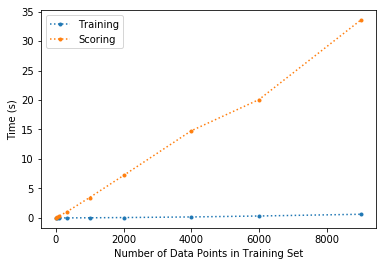

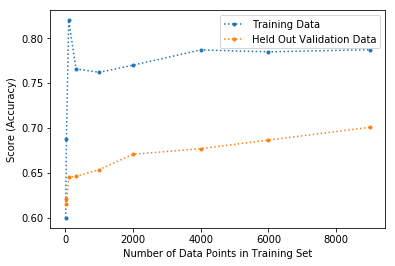

In [12]:
plotTimeCurve(lc, savefig = lcNameBase + "_time")
# plt.legend()
plt.show()

plotScoreCurve(lc, savefig = lcNameBase + "_score")
# plt.legend()
plt.show()

In [13]:
iBest = np.argmax(lc['test_score'])
bestScore = lc['test_score'][iBest]
bestData = lc['n_data'][iBest]
print(f'Best validation score of {bestScore:.3} achieved with {bestData:d} samples')

Best validation score of 0.701 achieved with 9000 samples


In [14]:
lc_params = copy.deepcopy(gs.best_params_)
lc_params['weights'] = 'distance'

lcNameBase = est + "_" + lc_params['weights'] + "_lc_" + str(len(learningCurveFolds)) + "f_" + str(X.shape[0]) + "ex"
lcName = lcNameBase  + ".pkl"

print(f"Computing learning curves with params: \n{lc_params}")
print(f"Over {len(learningCurveFolds)} folds: {learningCurveFolds}")
# Note that computeLearningCurve with testSize specified splits X, y into a test and validation set 
# before training (validation set is used for validation curve)
lc = computeLearningCurve(KNeighborsClassifier(**lc_params), X, y, testSize = testSize,
                          learningCurveFolds=learningCurveFolds, stratifyLearningCurveFolds=True, 
                         randomSeed=randomSeed, saveas=lcName, returnEstimators=True)

Computing learning curves with params: 
{'n_neighbors': 5, 'weights': 'distance'}
Over 9 folds: [  10   32  100  316 1000 2000 4000 6000 9000]
Indices included at fold 0: 10
	Model trained in 0.00s
	Model Scored on Training Data in 0.00s
	Model Scored on Test Data in 0.02s
	Total time for this iteration = 0.02s
Indices included at fold 1: 32
	Model trained in 0.00s
	Model Scored on Training Data in 0.00s
	Model Scored on Test Data in 0.13s
	Total time for this iteration = 0.14s
Indices included at fold 2: 100
	Model trained in 0.00s
	Model Scored on Training Data in 0.02s
	Model Scored on Test Data in 0.38s
	Total time for this iteration = 0.40s
Indices included at fold 3: 316
	Model trained in 0.01s
	Model Scored on Training Data in 0.16s
	Model Scored on Test Data in 1.11s
	Total time for this iteration = 1.28s
Indices included at fold 4: 1000
	Model trained in 0.03s
	Model Scored on Training Data in 1.53s
	Model Scored on Test Data in 3.64s
	Total time for this iteration = 5.20s
Ind

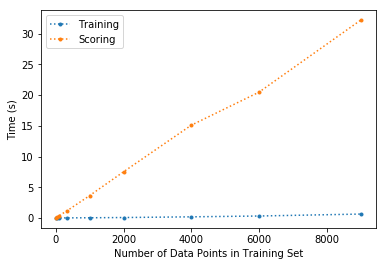

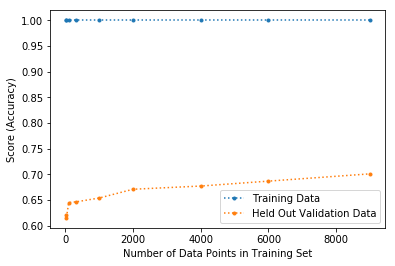

In [15]:
plotTimeCurve(lc, savefig = lcNameBase + "_time")
# plt.legend()
plt.show()

plotScoreCurve(lc, savefig = lcNameBase + "_score")
# plt.legend()
plt.show()

Note: Inverse distance weighted KNN always has 0 training error because requesting data for a point that is identical to one in the KNN's database results in a very large weight for that one record's result (1 / distance = 1 / 0 -> infinity).

In [16]:
iBest = np.argmax(lc['test_score'])
bestScore = lc['test_score'][iBest]
bestData = lc['n_data'][iBest]
print(f'Best validation score of {bestScore:.3} achieved with {bestData:d} samples')

Best validation score of 0.701 achieved with 9000 samples


# Refit Model on Best Data

Refit the model using a second GridSearchCV search for hyperparameters, then score the model on the held out test data. 

In [17]:
paramGrid = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['distance'],
}

nData = bestData
XSubset = X[:nData]
ySubset = y[:nData]

gs = GridSearchCV(KNeighborsClassifier(), param_grid=paramGrid, cv=nfolds, n_jobs=njobs, 
                      verbose=10, return_train_score=True)

In [18]:
# fit!
print(f"Fitting model using {XSubset.shape[0]} data samples")
gs.fit(XSubset, ySubset)

Fitting model using 9000 data samples
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:  3.7min remaining:  5.5min
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed:  7.0min remaining:  5.7min
[Parallel(n_jobs=-1)]: Done  14 out of  20 | elapsed:  7.1min remaining:  3.1min
[Parallel(n_jobs=-1)]: Done  17 out of  20 | elapsed:  9.4min remaining:  1.7min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  9.4min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  9.4min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_neighbors': [3, 5, 7, 10], 'weights': ['distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=10)

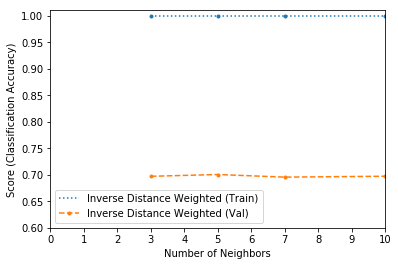

In [19]:
pltNameSuffix = '_final'

gs_results_df = pd.DataFrame(gs.cv_results_)

fig, ax = plt.subplots()

gs_results_df.loc[gs_results_df.param_weights == 'distance'].plot(x='param_n_neighbors', y='mean_train_score', label='Inverse Distance Weighted (Train)', ax=ax, marker='.', ls=":")
gs_results_df.loc[gs_results_df.param_weights == 'distance'].plot(x='param_n_neighbors', y='mean_test_score', label='Inverse Distance Weighted (Val)', ax=ax, marker='.', ls="--")
gs_results_df.to_csv(est + pltNameSuffix + "_gs_results.csv")

ax.set_xlabel("Number of Neighbors")
ax.set_ylabel(scoreText)
ax.xaxis.set_major_locator(MaxNLocator(integer=True)) # Force integer x axis
ax.set_xlim(left=0, right=gs_results_df.param_n_neighbors.max())
ax.set_ylim(bottom=accuracyMin, top=accuracyMax+.01)

fig.savefig(est + pltNameSuffix + "_gs")

In [20]:
print(f'From this, we choose the following parameters for the final model:\n{gs.best_params_}')
score = gs.score(XTest, yTest)
print(f'This model has score of {gs.best_score_} in cross validation for grid search and {score} on the held-out test data')

From this, we choose the following parameters for the final model:
{'n_neighbors': 5, 'weights': 'distance'}
This model has score of 0.7004444444444444 in cross validation for grid search and 0.696 on the held-out test data


# Confusion Matrix

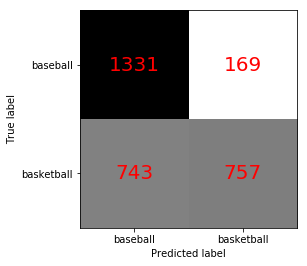

In [21]:
predictions = gs.predict(XTest)
ax = plotConfusionMatrix(yTest, predictions, names, savefig=est + pltNameSuffix + "_confusion")

# Examples of Incorrect Classifications

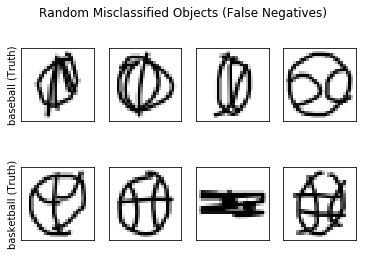

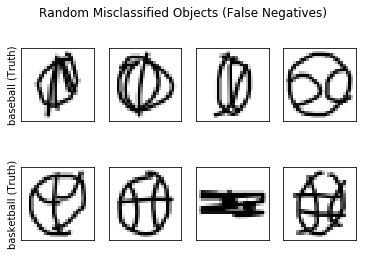

In [22]:
classNumbers = [nameDict[name] for name in names]
drawIncorrectSketches(XTest, yTest, predictions, classNumbers=[0, 1], names=names, n=4, randomSeed=randomSeed, savefig=est + pltNameSuffix + "_Misclassified")